In [2]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification
import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [4]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 25
stop_at = 5
cuda_card = 0

In [18]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions = read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    torch.cuda.manual_seed_all(seed_val)

    train_index, val_index = train_test_split(list(range(0, len(data_texts))), test_size=0.12, random_state=10, shuffle=True)
    train_index, val_index = np.array(train_index), np.array(val_index)
    
    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    #val_index = np.load('val_tmp.npy')
    #train_index = np.load('train_tmp.npy')
    print(hola)
    train_texts, train_labels, train_positions, train_target_words = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
    val_texts, val_labels, val_positions, val_target_words = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    train_dataset = LexDataset(train_encodings, train_labels, train_positions)
    train_loader = DataLoader(train_dataset, batch_size=16)

    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
    val_dataset = LexDataset(val_encodings, val_labels, val_positions)
    val_loader = DataLoader(val_dataset, batch_size=1)
    
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
    test_dataset = LexDataset(test_encodings, test_labels, test_positions)
    test_loader = DataLoader(test_dataset, batch_size=1)
        
    all_text = ' '.join(train_texts)
    occurence_text = [all_text.count(w) for w in val_target_words]
        
    occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
    device = torch.device(f"cuda:{cuda_card}")
        
    model = BertForSharedTaskBaseline.from_pretrained(
        "bert-base-uncased", 
        num_labels = 1, 
        output_attentions = False, 
        output_hidden_states = False, 
    )
    model.cuda(cuda_card)

    optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
        
    tracking_metrics_val = []
    tracking_logits_val = []
    
    tracking_metrics_test = []
    tracking_logits_test = []
    
    early_stopping = 0
    best_metric = 1000000
        
    for epoch_i in range(0, epochs):
        print()
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train(device, model, train_loader, forward_func_custom_bert, optimizer, scheduler)
        
        _, val_logits, val_metric = evaluate(device, model, val_loader, forward_func_custom_bert)
        _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_custom_bert)

        tracking_metrics_val.append(val_metric)
        tracking_logits_val.append(val_logits)
        
        tracking_metrics_test.append(test_metric)
        tracking_logits_test.append(test_logits)
        
        if val_metric > best_metric:
            early_stopping += 1
        else:
            best_metric = val_metric
            early_stopping = 0
                
        if early_stopping == stop_at:
            break
            
        index_min = np.argmin(tracking_metrics_val)
            
    history_labels_val.extend(val_labels)
    history_labels_test.extend(test_labels)
    history_preds_val.extend(tracking_logits_val[index_min])
    history_preds_test.extend(tracking_logits_test[index_min])
    history_samples_val.extend(val_texts)
    history_samples_test.extend(test_texts)
    history_input.extend(sentence_raw[val_index])
    history_input_test.extend(sentences_test)
    history_target.extend(target_words[val_index])
    history_target_test.extend(test_target_words)
    history_index.extend(([ix_fold] * len(val_index)))
    history_occur_text.extend(occurence_text)
    history_occur_target.extend(occurence_target)
    ix_fold += 1

    print("")
    print("Training complete!")
        
    del model
    torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = 0
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    results_window[window_x] = results

Window size of  0


NameError: name 'hola' is not defined

In [7]:
len(train_texts), len(val_texts)

(6147, 1085)

In [11]:
len(val_index), len(set(val_index))

(868, 868)

In [14]:
val_index_tmp = np.load('val_tmp.npy')
train_index_tmp = np.load('train_tmp.npy')
    

In [16]:
train_index_tmp

array([   0,    1,    2, ..., 7228, 7229, 7231])

In [19]:
train_index

array([ 851, 1080, 4565, ..., 1344, 4623, 1289])

In [20]:
a = list(range(0,1000))
b = [1] * 300 + [2] * 300 + [3] * 200 + [4] * 200

In [26]:
from sklearn.model_selection import KFold
kf = KFold(8, shuffle=True, random_state=0)
for train_index, val_index in kf.split(a, b):
    break

In [85]:
import random


In [86]:
train_index

array([670, 449,  70, 474, 626, 495, 673, 293, 711, 157, 469, 477, 646,
       556, 755, 296, 529, 414, 242, 178, 680, 865, 811, 877, 303, 747,
       872, 208, 546, 249, 786, 144, 774, 454, 596, 492,  88, 184, 229,
       276,  69, 177, 314, 575, 500,  51, 731, 396, 361, 949, 960, 763,
       739, 346, 922, 657, 806, 597, 942, 139, 570, 613, 273,  43, 605,
       250, 884, 577, 690, 631,  61, 275,  54, 929, 107, 166, 825, 121,
       321, 426, 964, 222, 664, 245, 927, 931,  46, 977, 517, 781, 879,
       179, 704, 687,  99, 845, 707, 563, 326, 733, 647, 838, 504, 438,
       703, 699, 847,  93, 419, 460, 580, 748, 225, 915, 863,  96, 180,
       759, 411, 700, 189, 455, 678, 336, 653, 355, 342, 511, 907, 594,
       400, 969, 696, 972, 286, 359, 176, 590, 168, 235, 160, 418, 102,
       375, 564, 555, 117,  58, 661, 246,  92, 928, 338, 407, 629, 944,
        76, 930, 765, 870, 354,   5, 941, 253, 762, 424, 498,  67, 237,
       871, 815, 241, 287, 818, 986, 533, 483, 676, 688, 349, 68

In [10]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [11]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
Valid:
MAE --- Mean: 0.0659  Std: 0.0
MSE --- Mean: 0.0072  Std: 0.0
Test:
MAE --- Mean: 0.0698  Std: 0.0
MSE --- Mean: 0.0087  Std: 0.0

Window of 1
Valid:
MAE --- Mean: 0.0695  Std: 0.0
MSE --- Mean: 0.008  Std: 0.0
Test:
MAE --- Mean: 0.0747  Std: 0.0
MSE --- Mean: 0.0104  Std: 0.0

Window of 2
Valid:
MAE --- Mean: 0.0734  Std: 0.0
MSE --- Mean: 0.0091  Std: 0.0
Test:
MAE --- Mean: 0.0804  Std: 0.0
MSE --- Mean: 0.0122  Std: 0.0



In [12]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [13]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


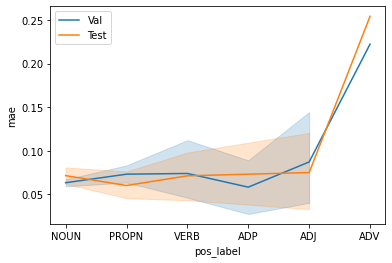

Window size of: 1


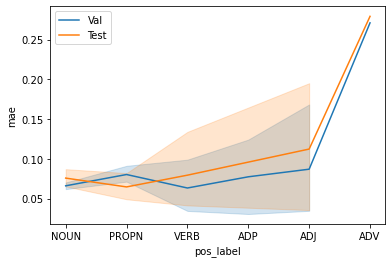

Window size of: 2


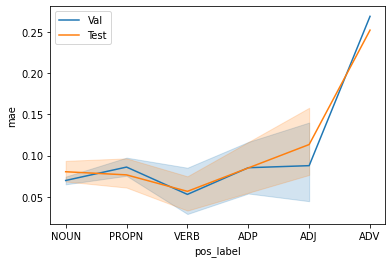

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()